In [51]:
import json
import pandas as pd
import seaborn as sns; sns.set()
import babeltrace as bl

In [60]:
tr = bl.TraceCollection()
tr.add_trace('yojson_traces', "ctf")

events = []
counters = []
allocs = []

ENTRY = 0
EXIT = 1
COUNTER = 2
ALLOC = 3


# babeltrace is an evil binding, do not put Event objects directly in a list, need to hard copy them.
# Events objects are actually references to the head of the iterator, so trying to use them from outside
# the scope of the iterator will results in having the same objects, that is, the last object iterated upon.
# ¯\_(ツ)_/¯

for event in tr.events:
    id = event['id']
    ev = {}
    ev['timestamp'] = event['timestamp']
    if id == ENTRY or id == EXIT:
        ev['phase'] = event['phase']
        ev['id'] = id
        events.append(ev)
    if id == COUNTER:
        ev['name'] = event['kind']
        ev['count'] = event['count']
        counters.append(ev)
    if id == ALLOC:
        ev['bucket'] = event['bucket']
        ev['count'] = event['count']
        allocs.append(ev)
    
timeline_set = {}
timeline = []

for event in events:
    phase = event['phase']
    if event['id'] == ENTRY:
        if phase in timeline_set:
            print("overlapping entry for phase: %s, timestamp %d" % (phase, event['timestamp']))
        else:
            timeline_set[phase] = event
    elif event['id'] == EXIT:
        if phase in timeline_set: 
            ev_entry = timeline_set[phase]
            item = {
                'ts_begin': ev_entry['timestamp'],
                'ts_end': event['timestamp'],
                'dur' : event['timestamp'] - ev_entry['timestamp'],
                'phase': phase
            }
            timeline.append(item)
            del timeline_set[phase]
        else:
            print("got an exit event with no entry: %s, timestamp %d" % (phase, event['timestamp']))
    
for key in timeline_set:
    print("got an entry event with no exit: %s, timestamp: %d" % (key, timeline_set[key]['timestamp']))

# FIXME: none of these should be tolerable besides impromptu program shutdown (segfault, abort... ect)

got an exit event with no entry: major/mark_final, timestamp 20734722
overlapping entry for phase: major/mark_roots, timestamp 50627562
got an exit event with no entry: major/mark_final, timestamp 50696239
overlapping entry for phase: major/mark_roots, timestamp 80786799
got an exit event with no entry: major/mark_final, timestamp 80901323
overlapping entry for phase: major/mark_roots, timestamp 110806724
got an exit event with no entry: major/mark_final, timestamp 110842858
overlapping entry for phase: major/mark_roots, timestamp 140460524
got an exit event with no entry: major/mark_final, timestamp 140544079
overlapping entry for phase: major/mark_roots, timestamp 183658757
got an exit event with no entry: major/mark_final, timestamp 183778841
overlapping entry for phase: major/mark_roots, timestamp 224305020
got an exit event with no entry: major/mark_final, timestamp 224350885
overlapping entry for phase: major/mark_roots, timestamp 272320237
got an exit event with no entry: major/

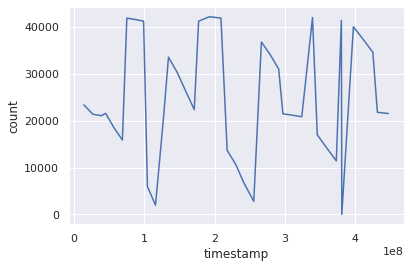

In [61]:
# From here, refer to https://github.com/Engil/gc-tracing/blob/master/metadata to know
# the various phases and counters available.

def counters_by_name(name): return [ev for ev in counters if ev['name'] == name]
def events_by_name(name): return [ev for ev in timeline if ev['phase'] == name]

s = pd.DataFrame(counters_by_name('minor/promoted'))

s['timestamp'] = s['timestamp'].astype('timedelta64[ns]')

sns.lineplot(x="timestamp", y="count", data=s)


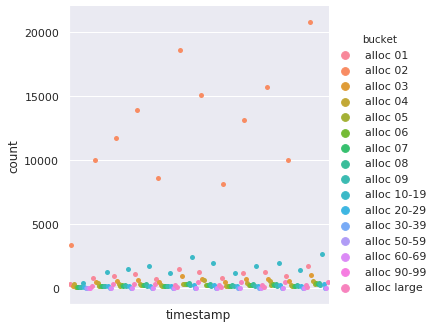

In [62]:
# Visiting allocations during the lifetime of the program, by buckets

s = pd.DataFrame(allocs)

ax = sns.catplot(x='timestamp', y='count', hue='bucket', data=s)
ax.set(xticks=[])


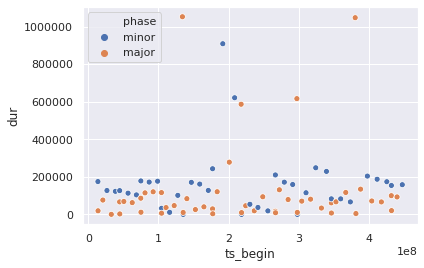

In [63]:
# minor and major dispatches, duration on the Y axis
s = pd.DataFrame([ev for ev in timeline if ev['phase'] == 'major' or ev['phase'] == 'minor'])
ax = sns.scatterplot(x='ts_begin', y='dur', hue='phase', data=s)

In [64]:
def gc_phase_quantile(name):
    s = pd.DataFrame(events_by_name(name))
    #s['timestamp'] = s['timestamp'].astype('timedelta64[ns]')
    return (s['dur'].quantile([.1, .25, .50, .75, .95, .99]))

In [65]:
gc_phase_quantile('major')

0.10       7323.80
0.25      19295.25
0.50      66604.50
0.75      98314.50
0.95     602807.75
0.99    1049599.97
Name: dur, dtype: float64

In [66]:
gc_phase_quantile('minor')

0.10      9734.00
0.25     74721.50
0.50    127810.00
0.75    175882.50
0.95    285527.10
0.99    799173.56
Name: dur, dtype: float64

In [68]:

gc_phase_quantile('major/sweep')

0.10     22161.5
0.25     41505.0
0.50     74788.5
0.75    116172.0
0.95    181393.0
0.99    255976.5
Name: dur, dtype: float64